In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle

In [2]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_17144/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [3]:
from sklearn.svm import SVC
from mvpa2.measures.base import CrossValidation
from mvpa2.clfs.meta import NFoldPartitioner
from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [4]:
from mvpa2.datasets.mri import fmri_dataset

In [5]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

In [6]:
from nilearn.masking import unmask

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.


Version 5 uses scikit-learn directly, bypassing mvpa2's framework altogether. We also implement a 'forced choice' scorer.

In [7]:
from visualization import visualize_corr
import mvpa2

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [8]:
from mvpa_sst_utils import *

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/mvpa_sst_utils.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown
/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/outlier_detection.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [9]:
import sys
import os

sys.path.append(os.path.abspath("../../ml/"))


## Load

In [10]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [11]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [12]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [13]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [14]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [15]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

## new code

In [16]:
from sklearn.model_selection import LeaveOneGroupOut

In [17]:
def remove_selected_outliers_mvpa_tesq_study(
    ind_div_combined,
    show_plot=False,
    neural_measures = ['CorGo_ln_inv_pred_prob_CorrectGo','CorStop_ln_inv_pred_prob_CorrectStop']):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','TESQ_E_sum','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','cancer_promoting_minus_preventing_FFQ','bf_1'] + neural_measures,
    show_plot=show_plot)
    return(idc_outliers_removed)

In [18]:

import math



## whole brain

In [19]:
from sklearn.model_selection import LeaveOneGroupOut

In [20]:
from sklearn.svm import SVC
#from mvpa2.measures.base import CrossValidation
#from mvpa2.clfs.meta import NFoldPartitioner
#from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


Now let's scale that up to the full dataset.

In [21]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [22]:
results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v5_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

relevant_mask = None

In [23]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [24]:
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [25]:
print(os.path.exists(results_filepath))

False


In [26]:
if os.path.exists(results_filepath):
    with open(results_filepath, 'rb') as pkl_file:
        forced_choice_results = pickle.load(pkl_file)
else:
    forced_choice_results = do_forced_choice(Brain_Data_allsubs)
    with open(results_filepath, 'wb') as pkl_file:
        pickle.dump(forced_choice_results,file=pkl_file)

    

..

KeyboardInterrupt: 

In [ ]:
forced_choice_results['sample_wise']

In [ ]:
total_score = np.mean(list(forced_choice_results['group_wise'].values()))
total_score

Alright--and how about if we don't do the forced-choice?

In [ ]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [ ]:
print(prediction)
print(forced_choice_prediction)

## masks

We get the same file this time, but we apply a mask before doing learning.

In [27]:
from generic_utils import *

In [28]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [29]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, error_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

### try out one mask

In [30]:
brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl"

#brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Insular Cortex.pkl"
#brain_data_filepath = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_response inhibition_association-test_z_FDR_0.01.pkl'

In [31]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


In [32]:
Brain_Data_allsubs[0].samples

array([[ 1.0382861 ,  1.0452528 ,  1.1514504 , ...,  0.7481537 ,
         0.5825023 , -0.31958684]], dtype=float32)

In [33]:


masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


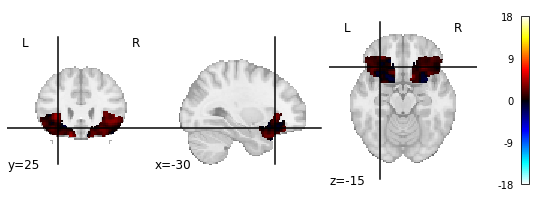

In [34]:
from nilearn import plotting

plotting.plot_stat_map(masked_preview,vmax=18)

In [35]:
from mvpa2.mappers.flatten import mask_mapper
import nibabel as nib

In [36]:
Brain_Data_allsubs.samples[np.isnan(Brain_Data_allsubs.samples)]=0

In [37]:
sum(sum(np.isnan(Brain_Data_allsubs[0,:].samples)))

0

In [38]:
Brain_Data_allsubs[0,:].samples

array([[ 1.0382861 ,  1.0452528 ,  1.1514504 , ...,  0.7481537 ,
         0.5825023 , -0.31958684]], dtype=float32)

In [39]:
forced_choice_results = do_forced_choice(Brain_Data_allsubs)

..............................

KeyboardInterrupt: 

In [ ]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
print(prediction,forced_choice_prediction)

yikes, that does seem a bit too good. Particularly considering that the non-forced-choice rsults are also up really high. We shouldn't be seeing resutls this high! Let's see how it goes across all the masks I have chosen.

In [ ]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

## normalization...

In [27]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [28]:
results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v3_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

### across series, training data only

In [41]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [48]:
Brain_Data_allsubs.samples.copy()

array([[ 0.7312383 ,  0.27183977, -0.09587598, ..., -0.9286324 ,
         0.68275356, -0.1660184 ],
       [-0.381091  , -0.41968623, -0.42312527, ..., -0.6829239 ,
        -0.12775972, -0.3424021 ],
       [-0.00422587, -0.6077599 , -0.9000941 , ..., -2.3298805 ,
        -0.33732155, -1.3221407 ],
       ...,
       [ 0.41749677,  0.32663387,  0.26954317, ...,  0.38780513,
        -0.2603853 ,  0.03476725],
       [ 0.25094506, -0.56350684, -1.2193519 , ...,  0.9981551 ,
         0.6138571 ,  0.8256795 ],
       [ 0.03494082, -0.22820817, -0.46821654, ..., -0.01853149,
        -0.21609281, -0.10853325]], dtype=float32)

In [61]:
print(np.mean(Brain_Data_allsubs.samples,axis=0))

[ 1.1773757e-08  0.0000000e+00 -7.3585982e-09 ... -1.1773757e-08
  6.6227386e-08  2.0604075e-08]


In [62]:
print(np.std(Brain_Data_allsubs.samples,axis=0))

[1.        1.0000001 1.        ... 1.        1.        0.9999999]


In [63]:
do_forced_choice(Brain_Data_allsubs,normalization="train_set_based")

.................................................................................

{'sample_wise':        chunk     target_y       pred_y pred_y_forced_choice  \
 0   DEV005_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV005_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV006_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV006_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV010_1    CorrectGo    CorrectGo            CorrectGo   
 ..       ...          ...          ...                  ...   
 1   DEV216_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV217_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV217_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV218_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV218_1  CorrectStop  CorrectStop          CorrectStop   
 
     pred_prob_CorrectGo  pred_prob_CorrectStop  
 0              0.928721               0.071279  
 1              0.148201               0.851799  
 0              0.974001               0.025999  
 1             

### across series, whole set

In [64]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [65]:
def bd_mean_across_images_per_voxel(bd):
    voxel_mean = np.mean(bd.samples,axis=0)
    voxel_sd = np.std(bd.samples,axis=0)
    bd.samples = (bd.samples-voxel_mean)/voxel_sd
    return(bd)

In [66]:
Brain_Data_allsubs = bd_mean_across_images_per_voxel(Brain_Data_allsubs)

In [69]:
norm_across_whole_set = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [90]:
def get_pred_fcp(x):
    prediction = np.mean(x['sample_wise']['target_y']==x['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(x['sample_wise']['target_y']==x['sample_wise']['pred_y_forced_choice'])
    return(prediction,forced_choice_prediction)

In [91]:
get_pred_fcp(norm_across_whole_set)

(0.9506172839506173, 0.9876543209876543)

## across each image

In [84]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [85]:
def bd_mean_across_voxels_per_img(bd):
    img_mean = np.mean(bd.samples,axis=1,keepdims=True)
    img_sd = np.std(bd.samples,axis=1,keepdims=True)
    bd.samples = (bd.samples-img_mean)/img_sd
    return(bd)

In [86]:
Brain_Data_allsubs = bd_mean_across_voxels_per_img(Brain_Data_allsubs)


In [87]:
norm_across_each_img = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [ ]:
prediction = np.mean(norm_across_each_img['sample_wise']['target_y']==norm_across_each_img['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(norm_across_each_img['sample_wise']['target_y']==norm_across_each_img['sample_wise']['pred_y_forced_choice'])

In [ ]:
prediction, forced_choice_prediction

## neural similarity

Previously we used neural similarity. this learner is actually more accurate, and what's more, we get a numeric probability which will be helpful.

Firstly, how can we re-eimplemnt the correlation I've already done?


def get_bd(brain_data_filepath,ns1,ns2,relevant_mask,condition1_name = 'PostError_similarity',condition2_name = 'PostCorrect_similarity',similarity_method='correlation'):
    bd=pickle.load(open(brain_data_filepath,'rb'))
    
    if relevant_mask is None:
        relevant_mask = nlt.Brain_Data(ns1).mask
    print("applying mask")
    bd_to_measure = bd.apply_mask(relevant_mask)
    #bd_PostError=bd[bd.X.condition_label=="CorrectGoFollowingFailedStop"]

    #bd.X.condition_label.value_counts()

    print("getting similarity 1")
    #bd.X[condition1_name] = (bd_to_measure.similarity(ns1))
    bd.X[condition1_name] = (nlt.Brain_Data(ns1).similarity(bd_to_measure,similarity_method))
    print("getting similarity 2")
    #bd.X[condition2_name] = (bd_to_measure.similarity(ns2))
    bd.X[condition2_name] = (nlt.Brain_Data(ns2).similarity(bd_to_measure,similarity_method))

    return(bd)

In [40]:
forced_choice_results['sample_wise'].rename({'chunk':'chunks'},axis=1,inplace=True)

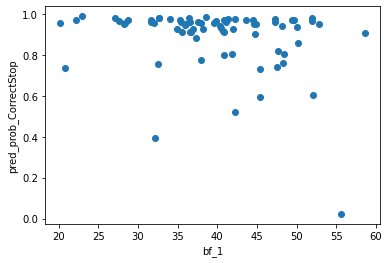

In [67]:
from visualization import visualize_corr

classifier = forced_choice_results['classifier']
sample_wise_results = forced_choice_results['sample_wise']
cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')

visualize_corr('bf_1','pred_prob_CorrectStop',full_dataset_cs)

In [48]:
import math

In [70]:
not_na_vals = np.isnan(full_dataset_cs.pred_prob_CorrectStop)==False
log_vals = [math.log(1-x) for x in (full_dataset_cs.pred_prob_CorrectStop[not_na_vals])]
full_dataset_cs.loc[not_na_vals,'pred_prob_CorrectStop_inv_ln']=log_vals

In [71]:
", ".join(individual_differences)

'subject, cancer_promoting_minus_preventing_FCI, cancer_promoting_minus_preventing_FFQ, cancer_promoting_minus_preventing_craved_FCI, cancer_promoting_minus_preventing_craved_FFQ, cancer_promoting_minus_preventing_liked_FCI, cancer_promoting_minus_preventing_liked_FFQ, cancer_promoting_FCI, cancer_promoting_FFQ, cancer_preventing_FCI, cancer_preventing_FFQ, BSCS, cSES, EDM, BIS_11, PCS, RS, TRSQ, bf_1, weight_0, height_0, birthsex, age365, bmi_0, bmi_1, bmi, bf_1_controlled, bf_1_bsexnormedzs, ACES_sum, ACES_household_dysfunction, ACES_neglectful_parenting, ACES_abuse, ACES_divorced_separated, BFI_agreeableness, BFI_conscientiousness, BFI_extraversion, BFI_neuroticism, BFI_openness, DEMO_mcarthur_social_standing, IMI_effort_importance, IMI_interest_enjoyment, IMI_perceived_choice, IMI_perceived_competence, IMI_value_usefulness, IPAQ_moderateminutes, IPAQ_sittinghours, IPAQ_vigorousminutes, IPAQ_walkingminutes, NCS_get_job_done, NCS_deliberating_issues, NCS_prefer_complex, NCS_prefer_li

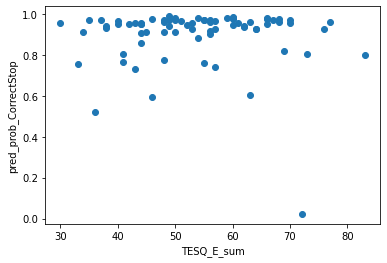

In [44]:
visualize_corr('TESQ_E_sum','pred_prob_CorrectStop',full_dataset_cs)

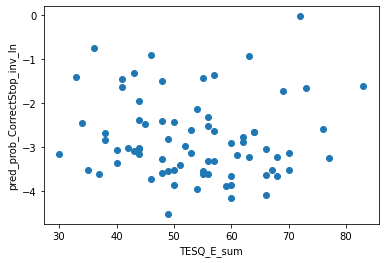

In [72]:
visualize_corr('TESQ_E_sum','pred_prob_CorrectStop_inv_ln',full_dataset_cs)

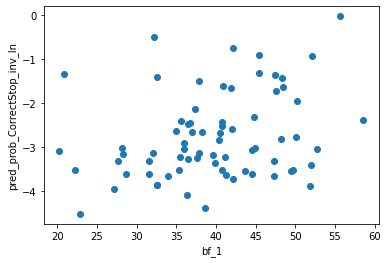

In [73]:
visualize_corr('bf_1','pred_prob_CorrectStop_inv_ln',full_dataset_cs)

Next to do:
1. Consider re-implementing LinearSVM and getting similarity rather than this probability measure
2. Visualize for all the other values.

Now we've decoupled the learner from the framework where we apply it, we can pass in any arbitrary learner. It just has to output:

1. predictions 
2. prediction confidence 
3. the classifier itself

### Re-implementing v3

This is a useful sanity check, becuase it's helpufl to try and explain why we're doing so much  better than rpeviously.

In [48]:

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


In [49]:
linear_results_with_similarity = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)

.................................................................................

In [50]:
forced_choice_results = linear_results_with_similarity

In [51]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [52]:
(prediction, forced_choice_prediction)

(0.691358024691358, 0.9012345679012346)

Formerly this was .85, .95, which was remarkable--we've now pretty clearly reproduced the result we were getting using nltools..

However, after I updated it based on documentation here (https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html) it performed less well. Not sure why the classifier is performing _less_ well in this setup than the former one - perhaps hte sort of normalization that I am doing on each side.

In [53]:
sample_wise_results = forced_choice_results['sample_wise']
cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')


In [54]:
from outlier_detection import *



In [55]:
full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
    full_dataset_cs,
    neural_measures = ['pred_prob_CorrectStop'])

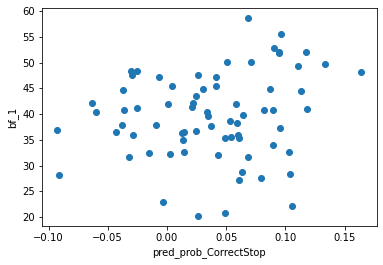

In [56]:
visualize_corr('pred_prob_CorrectStop','bf_1',full_dataset_cs)

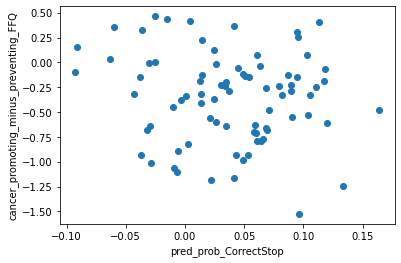

In [57]:
visualize_corr('pred_prob_CorrectStop','cancer_promoting_minus_preventing_FFQ',full_dataset_cs)

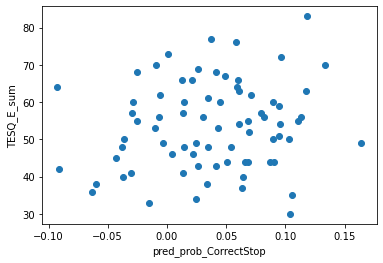

In [58]:
visualize_corr('pred_prob_CorrectStop','TESQ_E_sum',full_dataset_cs)

#### v3 mask

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7407407407407407 0.9629629629629629
executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7037037037037037 0.8641975308641975
response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6851851851851852 0.9753086419753086
inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6172839506172839 0.8765432098765432
harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6666666666666666 0.9135802469135802
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7098765432098766 0.9382716049382716
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.691358024691358 0.9012345679012346


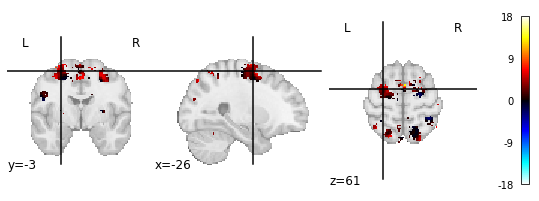

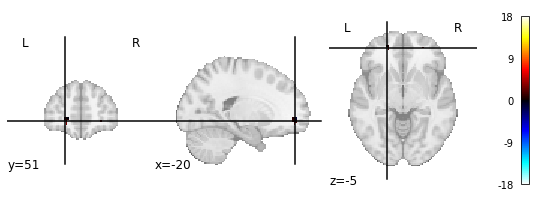

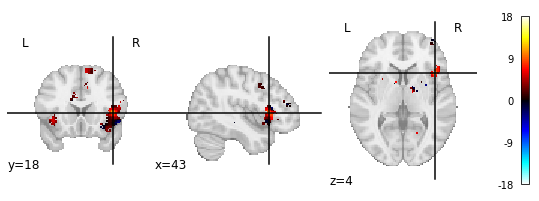

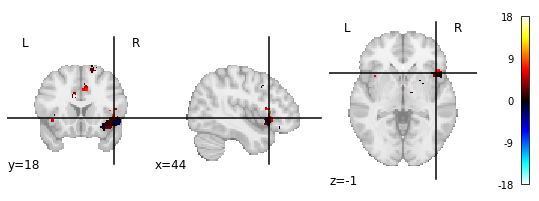

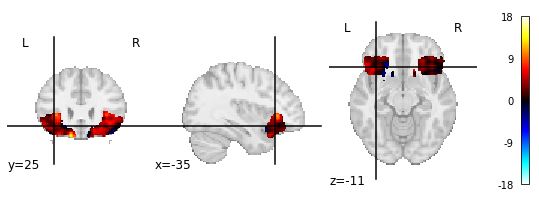

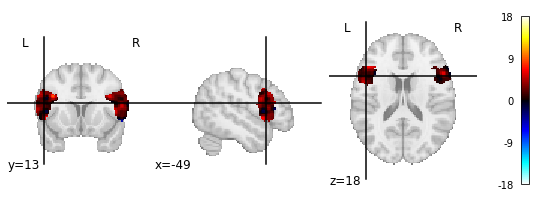

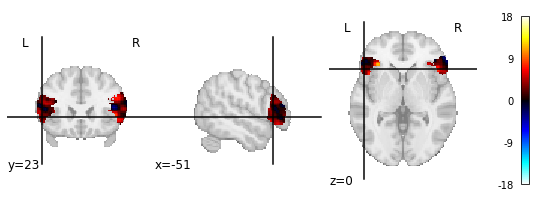

In [59]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

planning_association-test_z_FDR_0.01
(0.7407407407407407, 0.9629629629629629)


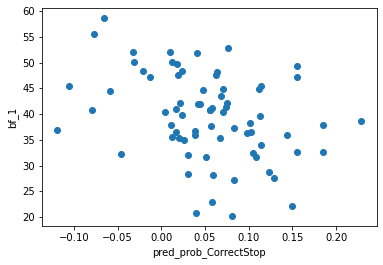

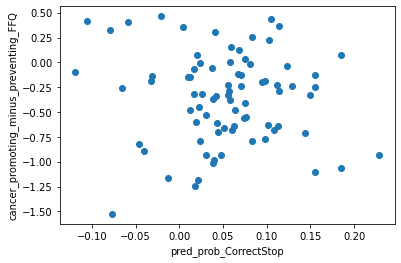

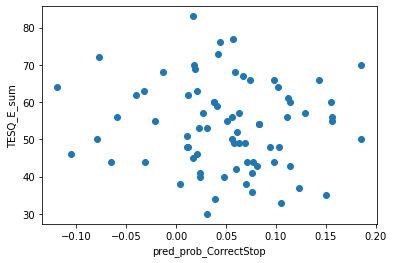

executive function_association-test_z_FDR_0.01
(0.7037037037037037, 0.8641975308641975)


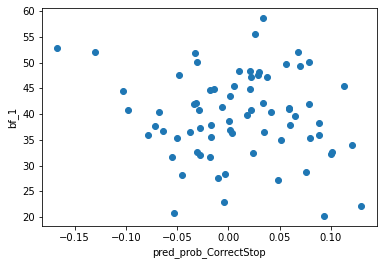

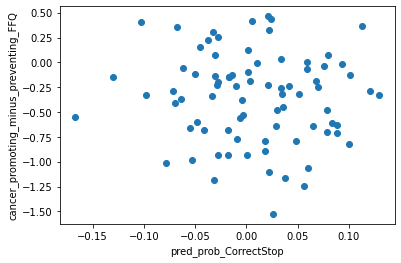

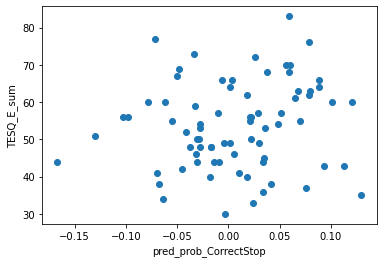

response inhibition_association-test_z_FDR_0.01
(0.6851851851851852, 0.9753086419753086)


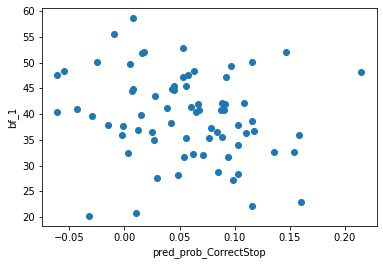

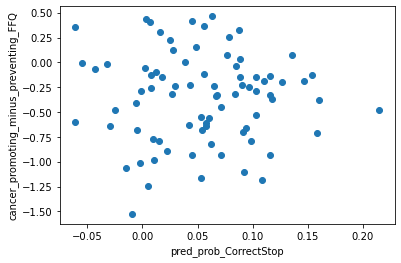

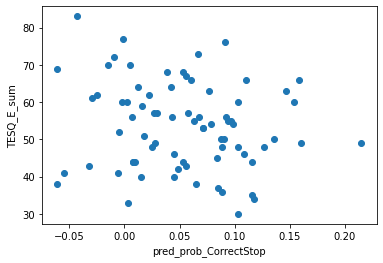

inhibition_association-test_z_FDR_0.01
(0.6172839506172839, 0.8765432098765432)


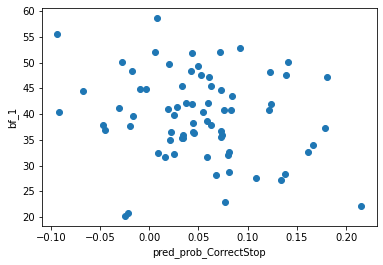

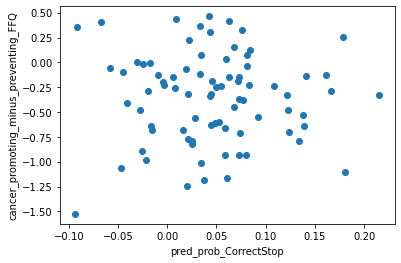

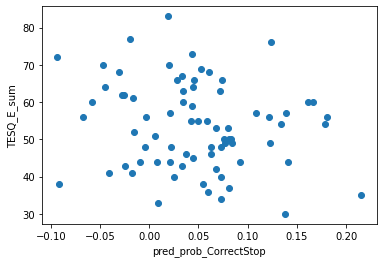

harvardoxford-cortical_prob_Frontal Orbital Cortex
(0.6666666666666666, 0.9135802469135802)


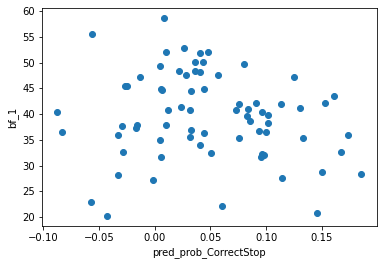

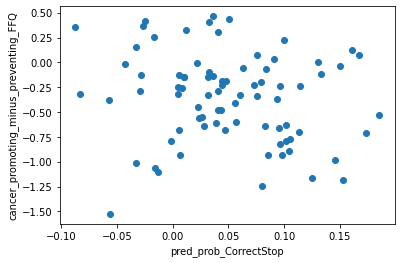

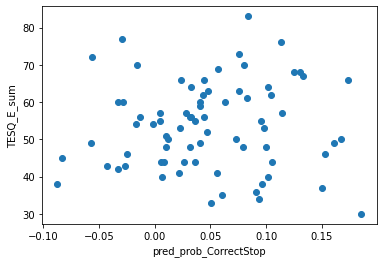

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
(0.7098765432098766, 0.9382716049382716)


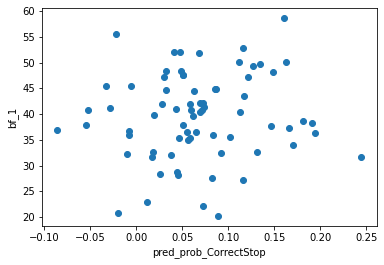

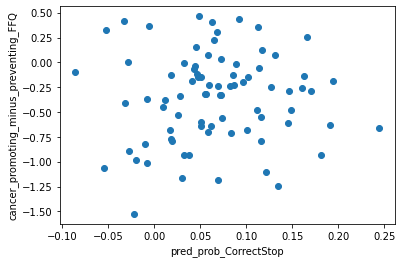

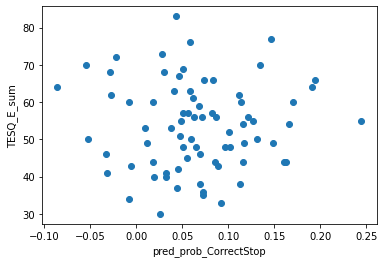

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
(0.691358024691358, 0.9012345679012346)


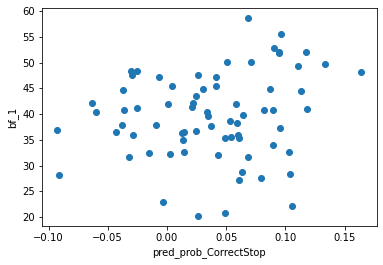

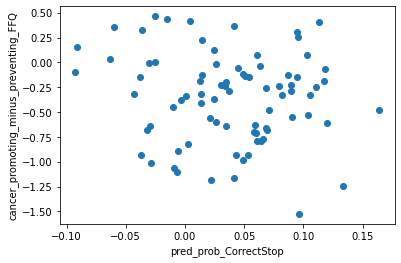

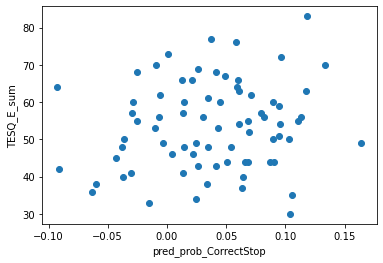

In [60]:
for k in forced_choice_results_dict.keys():
    v=forced_choice_results_dict[k]
    print(k)
    print_forced_choice_results(
        v,
        individual_differences,
        ['pred_prob_CorrectStop'])

## Apply the main analysis, looping through masks

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


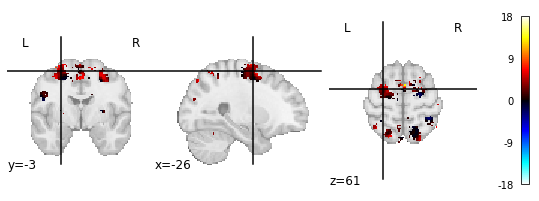

.................................................................................
0.9320987654320988 0.9876543209876543
(0.9320987654320988, 0.9876543209876543)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -2.384658
4                       -2.315528
..                            ...
196                     -3.092546
197                           NaN
198                           NaN
199                           NaN
200                     -3.353519

[201 rows x 1 columns]


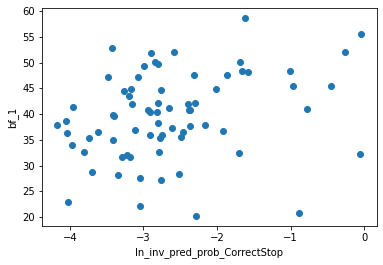

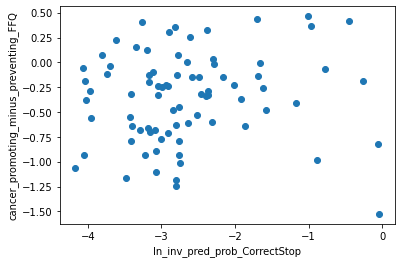

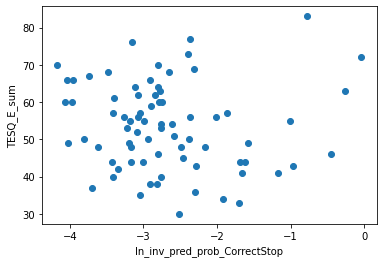

executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


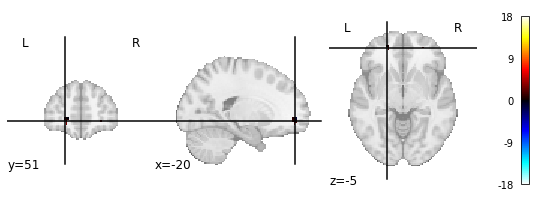

.................................................................................
0.9135802469135802 0.9753086419753086
(0.9135802469135802, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -2.433404
4                       -1.668112
..                            ...
196                     -1.347880
197                           NaN
198                           NaN
199                           NaN
200                     -3.537067

[201 rows x 1 columns]


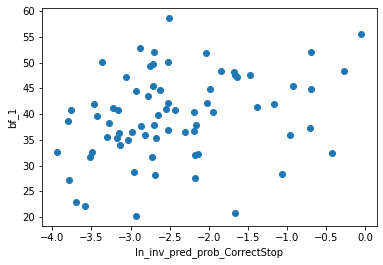

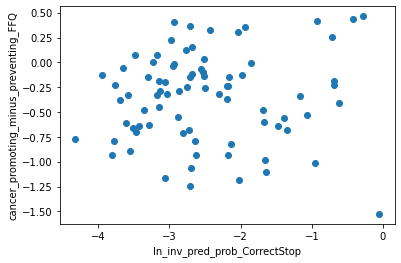

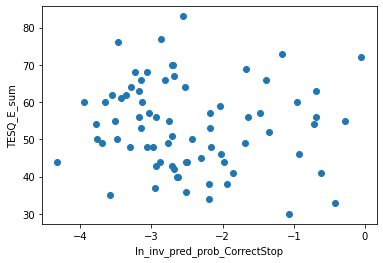

response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


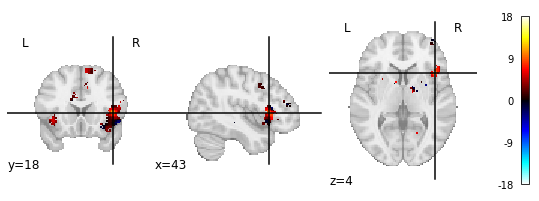

.................................................................................
0.9382716049382716 0.9753086419753086
(0.9382716049382716, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -3.382822
4                       -2.811562
..                            ...
196                     -1.979105
197                           NaN
198                           NaN
199                           NaN
200                     -3.582056

[201 rows x 1 columns]


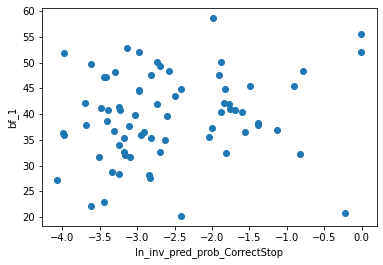

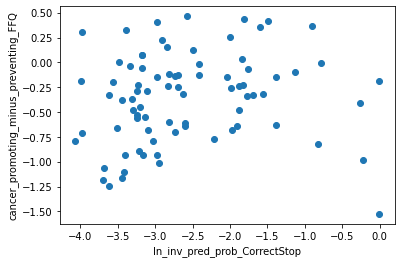

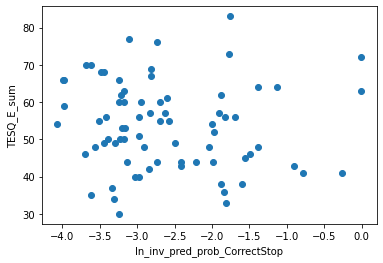

inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


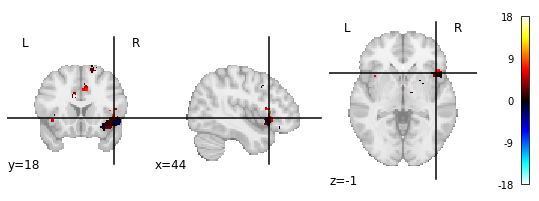

.................................................................................
0.9259259259259259 0.9753086419753086
(0.9259259259259259, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -2.681331
4                       -3.021033
..                            ...
196                     -2.283747
197                           NaN
198                           NaN
199                           NaN
200                     -3.602644

[201 rows x 1 columns]


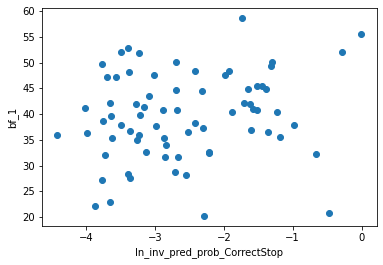

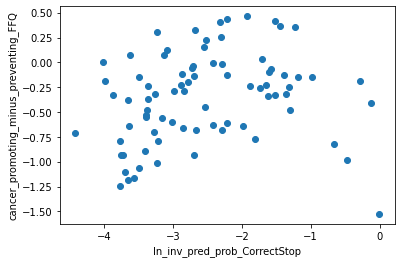

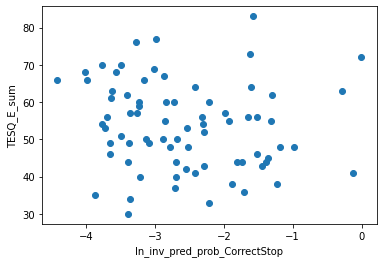

harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


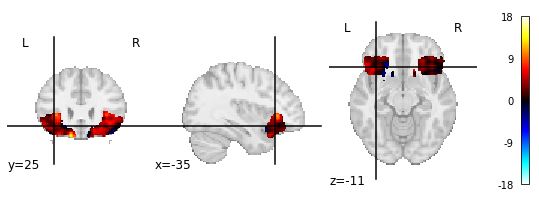

.................................................................................
0.9506172839506173 0.9753086419753086
(0.9506172839506173, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -2.946788
4                       -2.720058
..                            ...
196                     -2.606764
197                           NaN
198                           NaN
199                           NaN
200                     -2.711274

[201 rows x 1 columns]


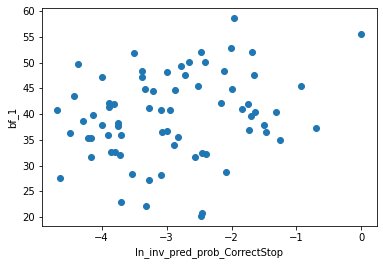

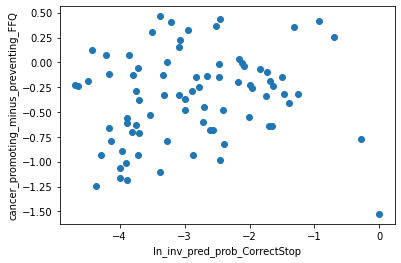

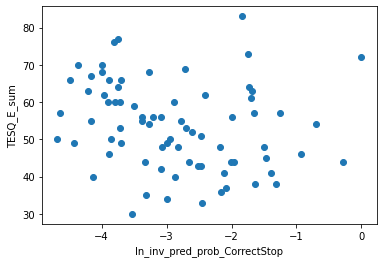

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


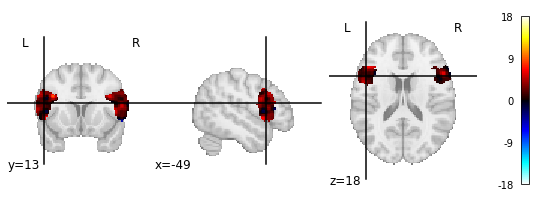

.................................................................................
0.9320987654320988 0.9753086419753086
(0.9320987654320988, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -2.735293
4                       -2.368246
..                            ...
196                     -2.991615
197                           NaN
198                           NaN
199                           NaN
200                     -2.445522

[201 rows x 1 columns]


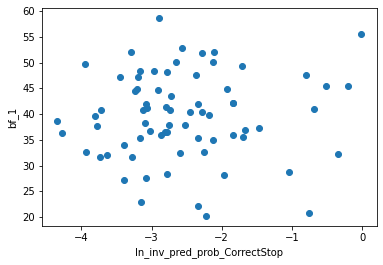

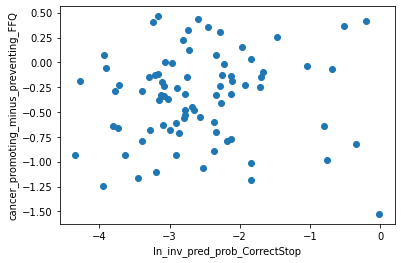

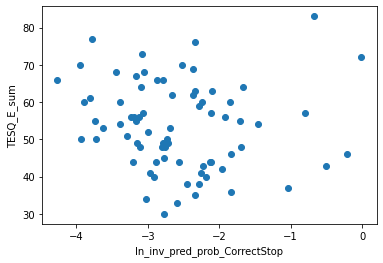

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


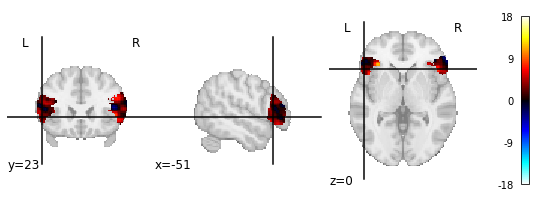

.................................................................................
0.9444444444444444 0.9753086419753086
(0.9444444444444444, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -2.693219
4                       -2.317886
..                            ...
196                     -4.100829
197                           NaN
198                           NaN
199                           NaN
200                     -2.384806

[201 rows x 1 columns]


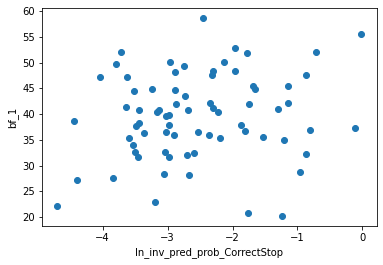

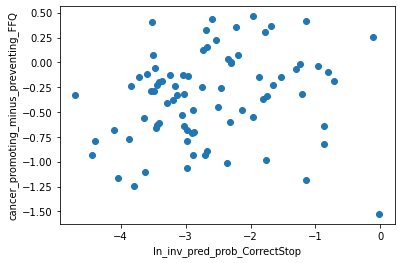

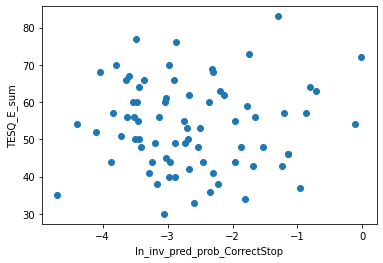

In [67]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectStop'])


        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(
            forced_choice_results,
            individual_differences,
            ['ln_inv_pred_prob_CorrectStop'])

whole brain
127427.37037037036
.................................................................................0.9506172839506173 0.9876543209876543
(0.9506172839506173, 0.9876543209876543)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                       -2.421457
4                       -1.676303
..                            ...
196                     -2.815866
197                           NaN
198                           NaN
199                           NaN
200                     -3.778719

[201 rows x 1 columns]


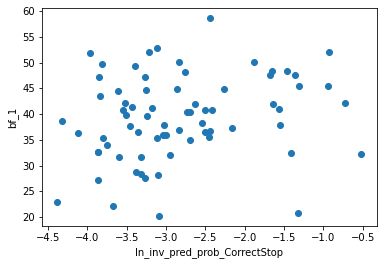

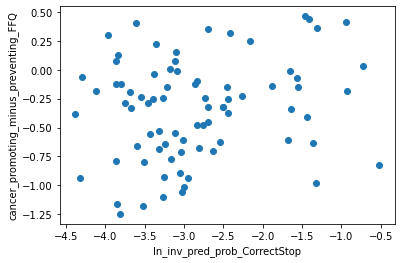

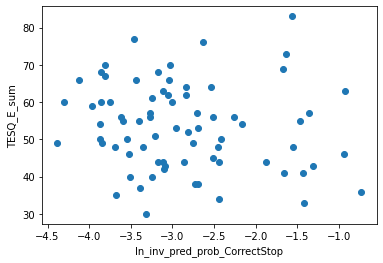

In [68]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CorrectStop'])

# Loop through correlation items

In [69]:
brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl"

results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v5_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

relevant_mask = None

In [70]:
if os.path.exists(results_filepath):
    with open(results_filepath, 'rb') as pkl_file:
        forced_choice_results = pickle.load(pkl_file)
else:
    forced_choice_results = do_forced_choice(Brain_Data_allsubs)
    with open(results_filepath, 'wb') as pkl_file:
        pickle.dump(forced_choice_results,file=pkl_file)

    

Now--loop through the items, and then loop through masks

In [71]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [72]:

import math
def inv_log_transform(series):
    series=series.copy()
    not_na_vals = np.isnan(series)==False
    log_vals = [math.log(1-x) for x in (series[not_na_vals])]
    series[not_na_vals] = log_vals
    return(log_vals)


sample_wise_results = forced_choice_results['sample_wise']   
sample_wise_results['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
sample_wise_results['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



In [73]:
sample_wise_results

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop,ln_inv_pred_prob_CorrectGo,ln_inv_pred_prob_CorrectStop
0,DEV005_1,CorrectGo,CorrectGo,CorrectGo,0.950488,0.049512,-3.005542,-0.050780
1,DEV005_1,CorrectStop,CorrectStop,CorrectStop,0.088201,0.911799,-0.092336,-2.428138
0,DEV006_1,CorrectGo,CorrectGo,CorrectGo,0.992946,0.007054,-4.954176,-0.007079
1,DEV006_1,CorrectStop,CorrectStop,CorrectStop,0.179542,0.820458,-0.197892,-1.717347
0,DEV010_1,CorrectGo,CorrectGo,CorrectGo,0.989892,0.010108,-4.594446,-0.010159
...,...,...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectStop,0.236497,0.763503,-0.269838,-1.441819
0,DEV217_1,CorrectGo,CorrectGo,CorrectGo,0.984806,0.015194,-4.186848,-0.015311
1,DEV217_1,CorrectStop,CorrectStop,CorrectStop,0.050841,0.949159,-0.052179,-2.979056
0,DEV218_1,CorrectGo,CorrectStop,CorrectGo,0.517527,0.482473,-0.728830,-0.658694


In [74]:


correct_go_probs = sample_wise_results.loc[
    sample_wise_results.target_y=='CorrectGo',
    ['chunks','ln_inv_pred_prob_CorrectGo','ln_inv_pred_prob_CorrectStop']
]
correct_go_probs.columns = ["CorGo_"+ cname for cname in correct_go_probs.columns]

correct_stop_probs = sample_wise_results.loc[
    sample_wise_results.target_y=='CorrectStop',
    ['chunks','ln_inv_pred_prob_CorrectGo','ln_inv_pred_prob_CorrectStop']
]
correct_stop_probs.columns = ["CorStop_"+ cname for cname in correct_stop_probs.columns]

cor_go_stop = correct_go_probs.merge(correct_stop_probs,left_on='CorGo_chunks',right_on='CorStop_chunks')
cor_go_stop.drop('CorStop_chunks',inplace=True,axis=1)
cor_go_stop.rename({'CorGo_chunks':'chunks'},inplace=True,axis=1)

In [75]:
cor_go_stop

,chunks,CorGo_ln_inv_pred_prob_CorrectGo,CorGo_ln_inv_pred_prob_CorrectStop,CorStop_ln_inv_pred_prob_CorrectGo,CorStop_ln_inv_pred_prob_CorrectStop
0,DEV005_1,-3.005542,-0.050780,-0.092336,-2.428138
1,DEV006_1,-4.954176,-0.007079,-0.197892,-1.717347
2,DEV010_1,-4.594446,-0.010159,-0.088889,-2.464482
3,DEV011_1,-2.224268,-0.114453,-0.060926,-2.828398
4,DEV013_1,-2.633643,-0.074526,-0.019450,-3.949606
...,...,...,...,...,...
76,DEV206_1,-2.953129,-0.053587,-0.028089,-3.586405
77,DEV215_1,-4.177023,-0.015463,-0.043914,-3.147388
78,DEV216_1,-5.519182,-0.004017,-0.269838,-1.441819
79,DEV217_1,-4.186848,-0.015311,-0.052179,-2.979056


In [76]:


individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
full_dataset_cs = individual_differences.merge(cor_go_stop,how='outer',left_on='subj_wave',right_on='chunks')


In [77]:
full_dataset_cs = remove_selected_outliers_mvpa_study(full_dataset_cs)

### CorGo_ln_inv_pred_prob_CorrectGo

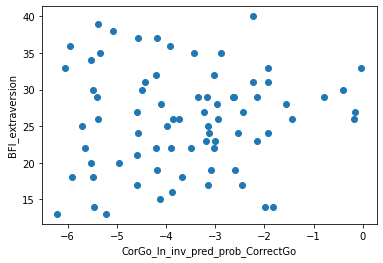

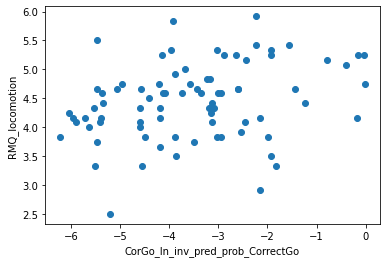

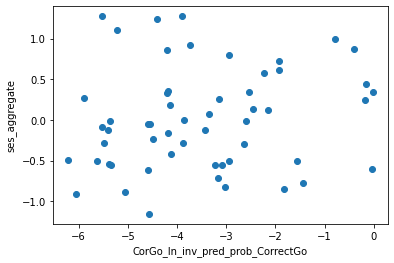

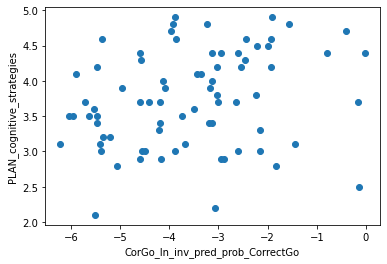

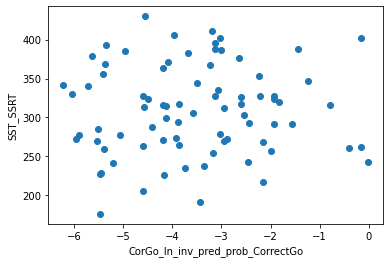

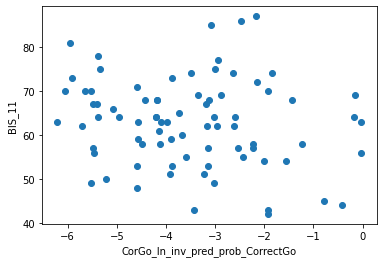

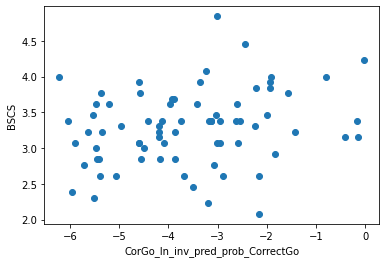

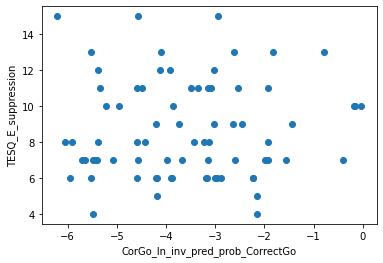

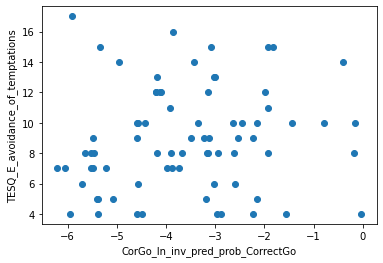

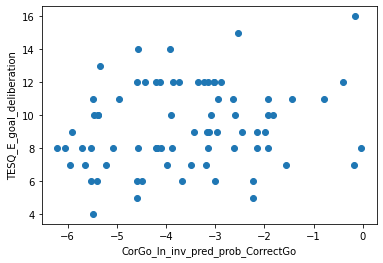

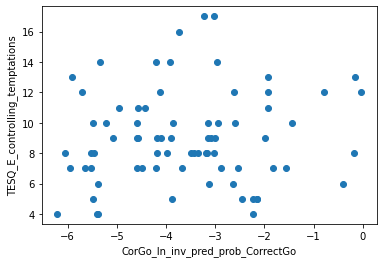

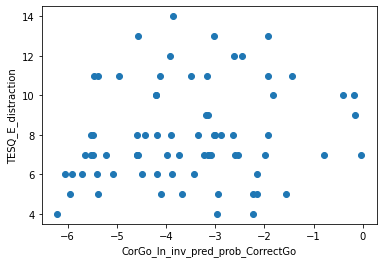

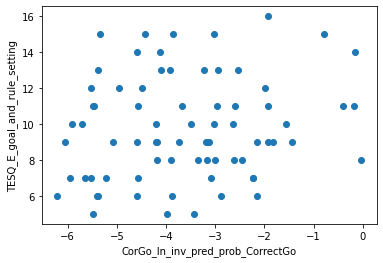

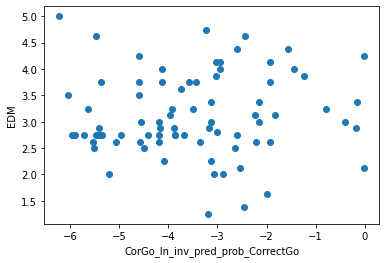

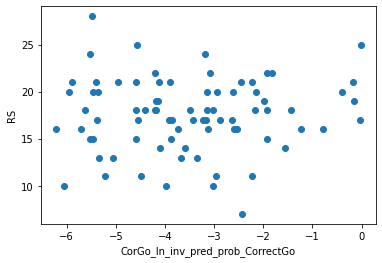

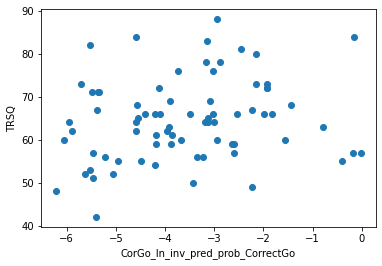

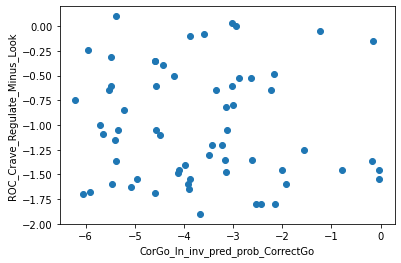

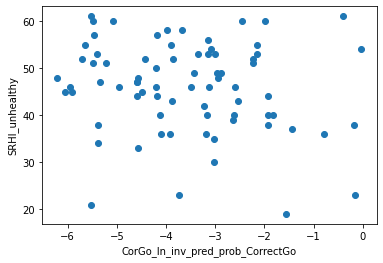

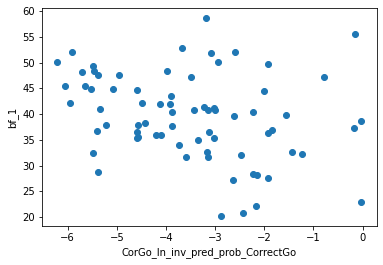

### CorStop_ln_inv_pred_prob_CorrectStop

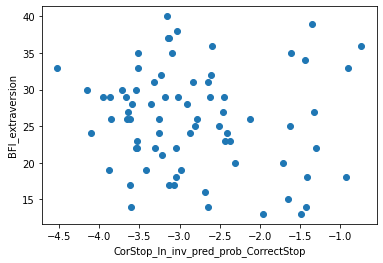

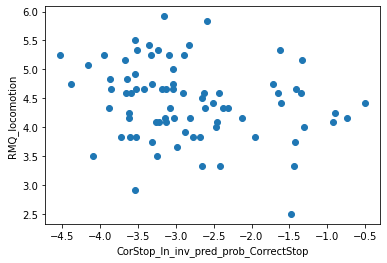

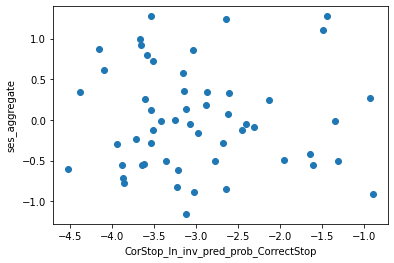

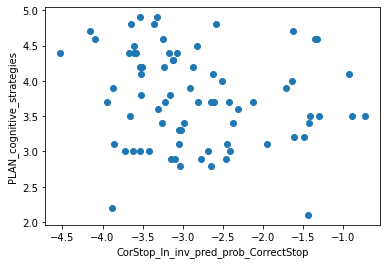

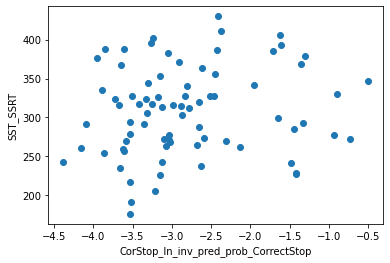

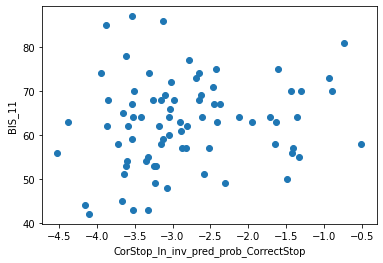

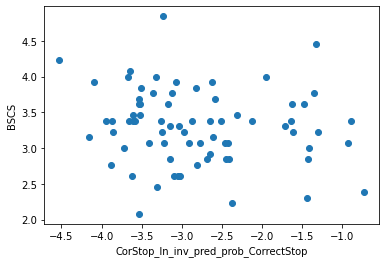

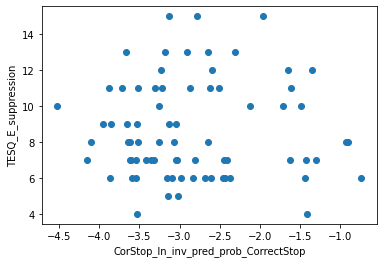

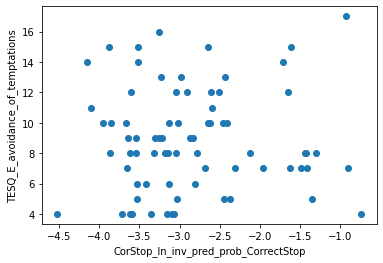

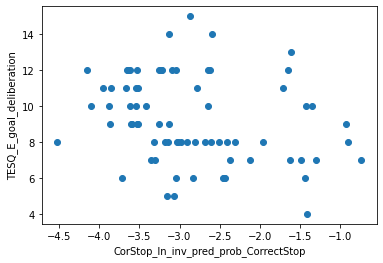

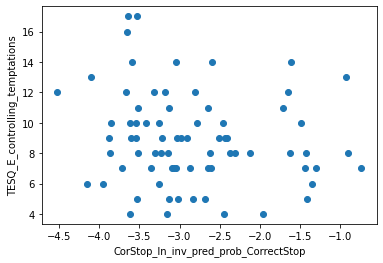

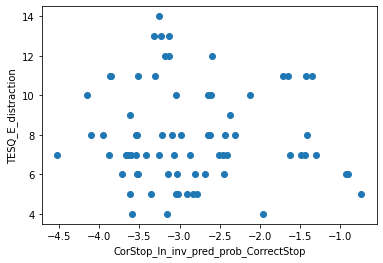

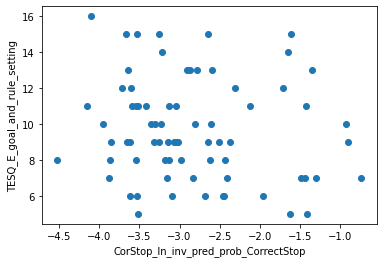

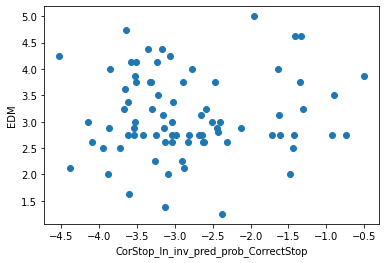

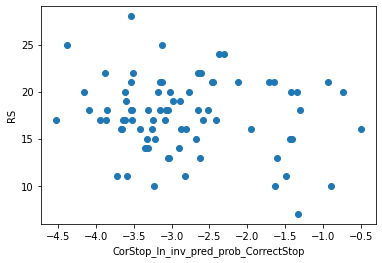

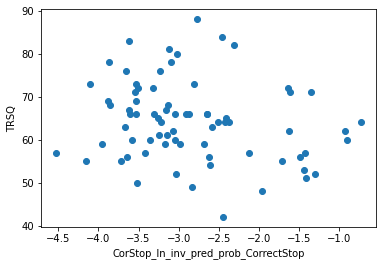

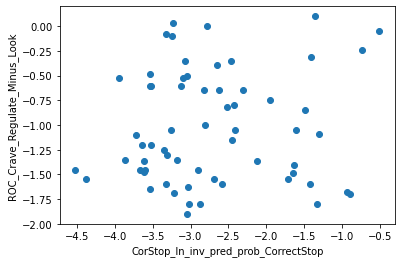

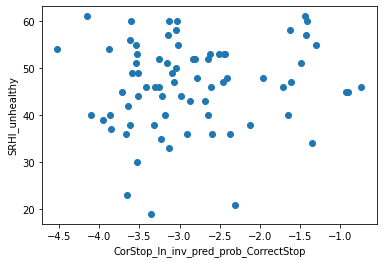

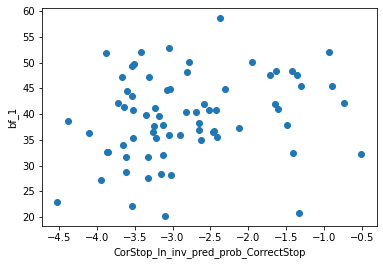

In [78]:

for neural_var in ['CorGo_ln_inv_pred_prob_CorrectGo','CorStop_ln_inv_pred_prob_CorrectStop']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy','bf_1']:
        visualize_corr(neural_var,correlate,full_dataset_cs)
        

## Contrast between CorrectStop and CorrectGo...

In [81]:
#", ".join(sa_to_df(Brain_Data_allsubs.sa).columns)

planning_association-test_z_FDR_0.01
1685.1518987341772


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


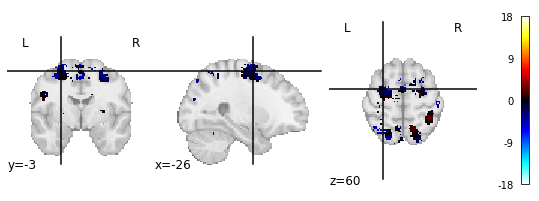

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


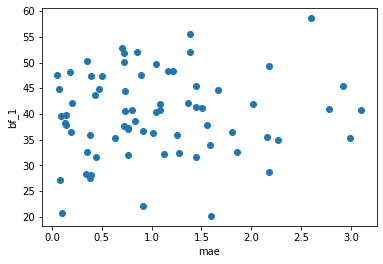

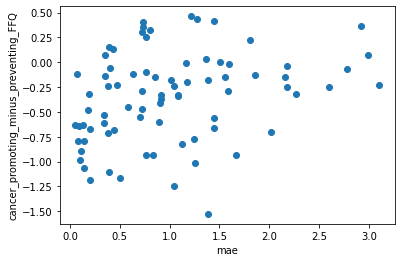

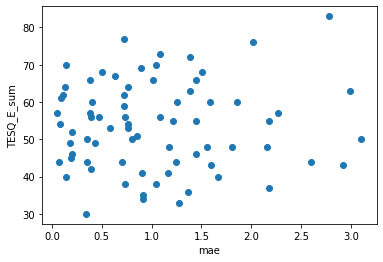

executive function_association-test_z_FDR_0.01
77.50632911392405


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


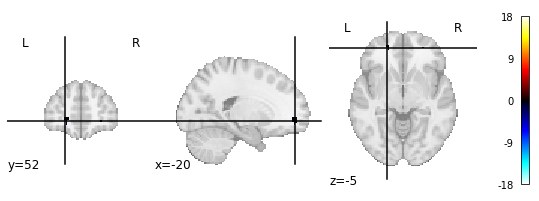

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


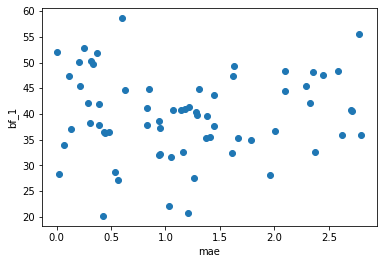

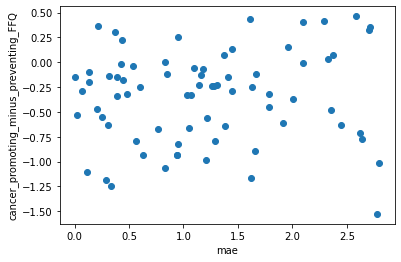

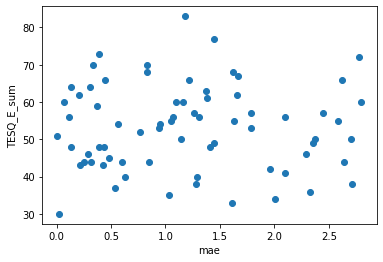

response inhibition_association-test_z_FDR_0.01
1291.1645569620252


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


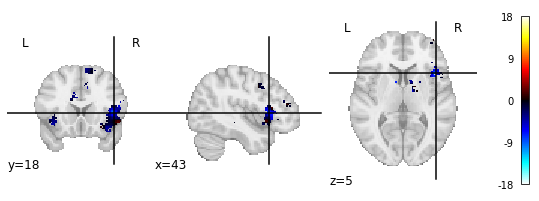

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


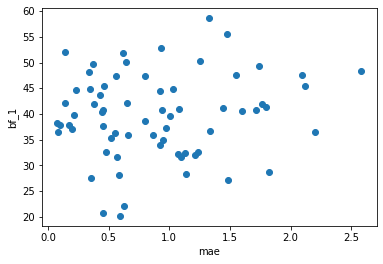

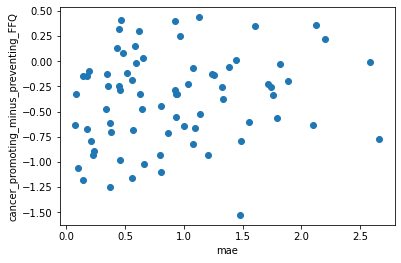

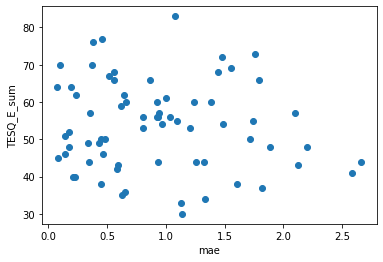

inhibition_association-test_z_FDR_0.01
436.0886075949367


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


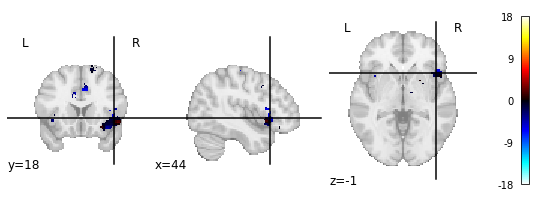

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


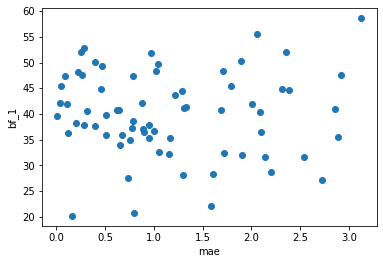

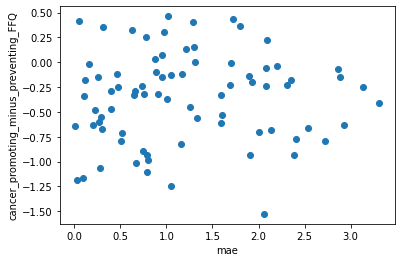

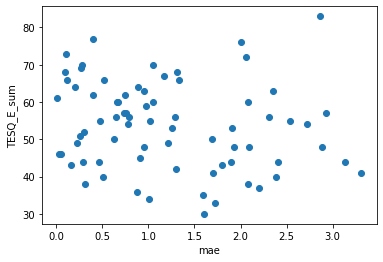

harvardoxford-cortical_prob_Frontal Orbital Cortex
2847.012658227848


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


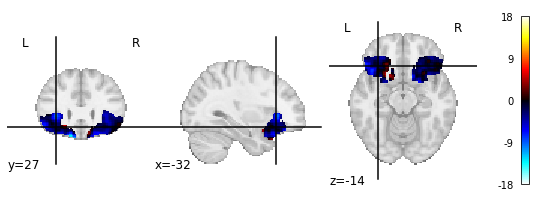

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


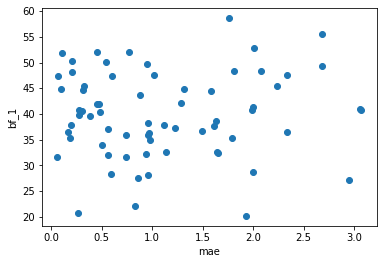

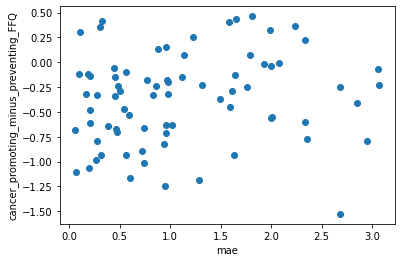

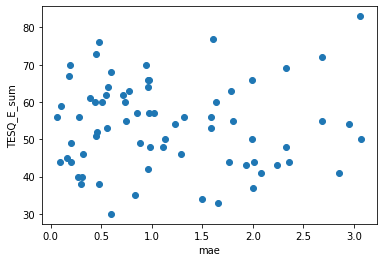

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
1471.4303797468353


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


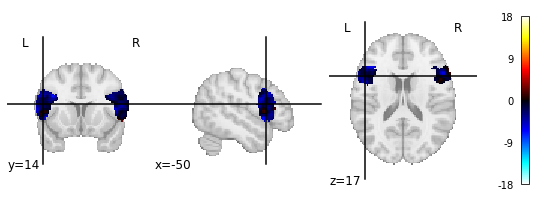

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


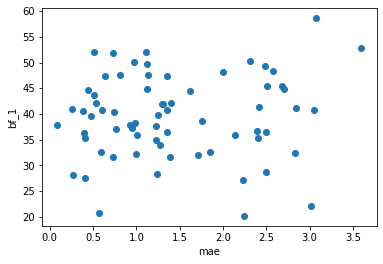

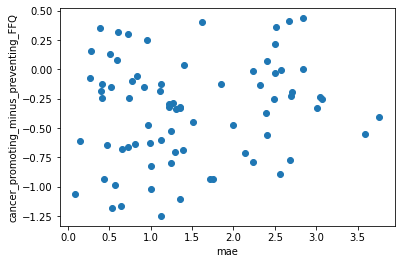

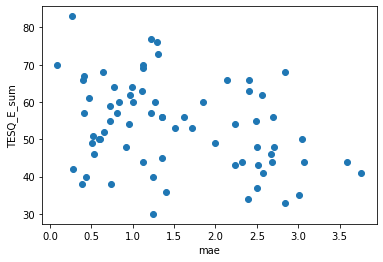

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
1538.620253164557


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


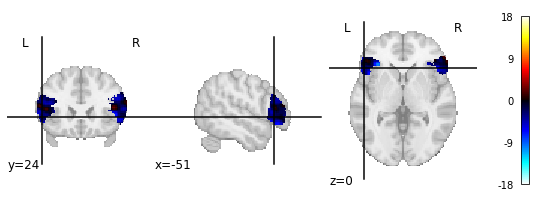

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


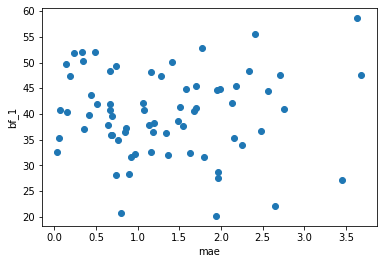

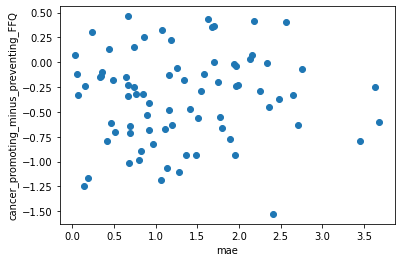

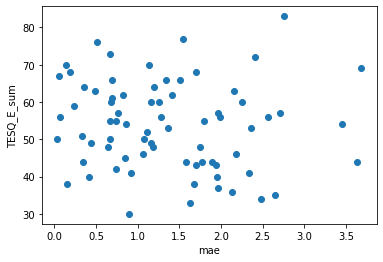

In [82]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):

        target='SST_SSRT'

        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)

        Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
        print("")

#             prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
#             forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

#             forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
#             forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



        #print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_regression_results(forced_choice_results,['mae'])

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
108520.02531645569


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


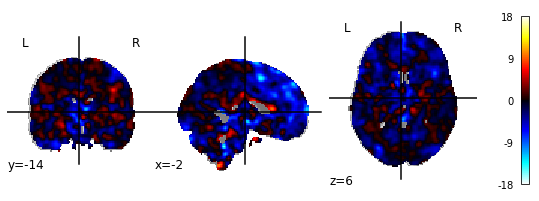

...

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.3466e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.55211e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27406e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.11435e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.01995e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22174e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1365e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29197e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.37195e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14587e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.3401e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.4792e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.13074e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.51638e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.10771e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42884e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16605e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24135e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27849e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.17444e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.51536e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.03639e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.32662e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.47439e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.263e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14526e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24325e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.36e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.33944e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41993e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16458e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16236e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27412e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.81581e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41303e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29131e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22977e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.99843e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.44902e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.88395e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.28041e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1843e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.78835e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16703e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.57511e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42558e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.4367e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.63866e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.40746e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.23091e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29997e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22218e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.05825e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.30593e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.46081e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24517e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.43528e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42074e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.99017e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1692e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41775e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22715e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.34319e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.15753e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.10879e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24447e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27121e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22157e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27406e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.06374e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.056e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.48659e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.05474e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16402e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22216e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14187e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29135e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.13431e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)



Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.32289e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.00275e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


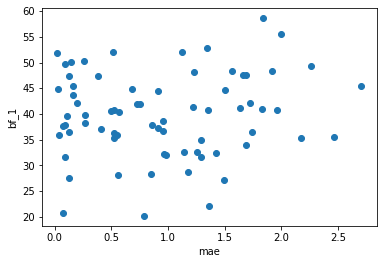

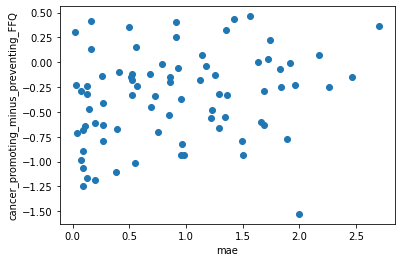

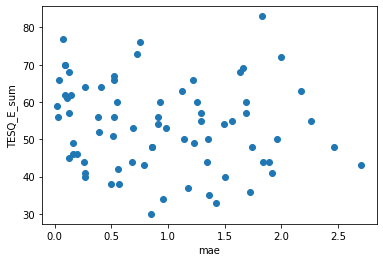

In [83]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast.pkl"
)

target='SST_SSRT'

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

print(mask_name)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(masked_preview,vmax=18)
plotting.show()
forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
print("")


forced_choice_results_dict[mask_name]=forced_choice_results
print_regression_results(forced_choice_results,['mae'])

# v5 on PES

Here we're going to run the same "version 5" analysis as above, but on the PES contrast instead. Should be straightforward to replicate.


In [40]:
pes_vars_of_interest  =['RTFS_factor_1','RTFS_factor_2','RTFS_f1_minus_f2', 'SST_PostErrorSlowW1_median','SST_PostErrorSlowW1_mean','SST_pes_mean_limited','FFQ_v2_Mean_Weighted_Nutrient_Density']


## discriminability

In [41]:
from generic_utils import *
## additional masks

all_masks = get_failure_masks(ml_data_folderpath)

### masked, conditions separate

In [42]:
all_masks

,mask_name,mask_filepath,thresh
0,negative affect_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
1,emotion regulation_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
2,harvardoxford-cortical_prob_Frontal Medial Cortex,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
3,negative emotions_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
4,self referential_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
5,harvardoxford-cortical_prob_Frontal Orbital Co...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
6,"harvardoxford-cortical_prob_Cingulate Gyrus, a...",/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0


/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative affect_association-test_z_FDR_0.01.pkl
negative affect_association-test_z_FDR_0.01
1170.0925925925926


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


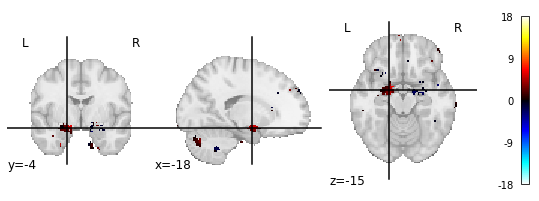

.................................................................................0.6234567901234568 0.35802469135802467
(0.6234567901234568, 0.35802469135802467)


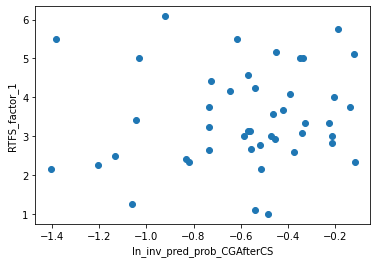

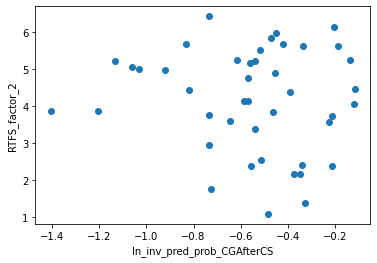

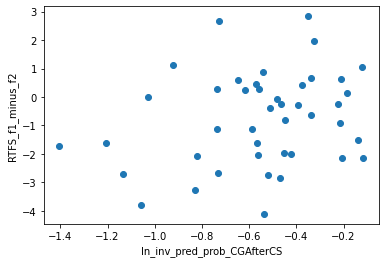

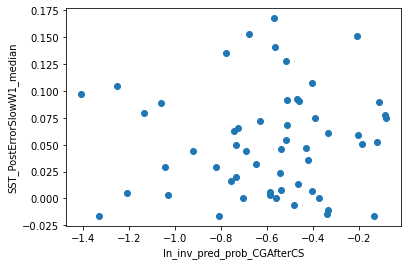

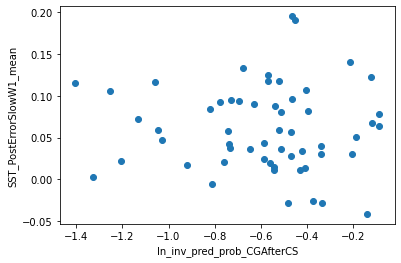

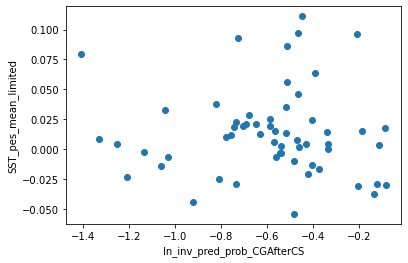

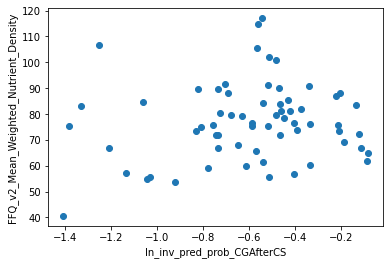

(0.6234567901234568, 0.35802469135802467)


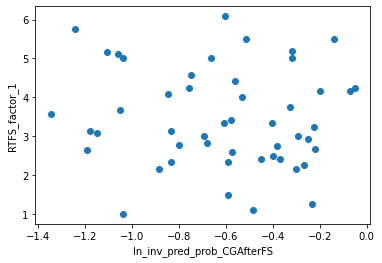

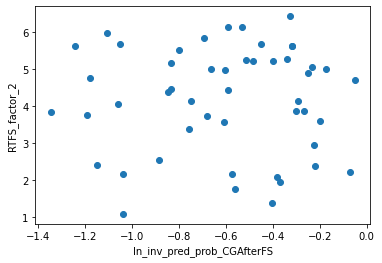

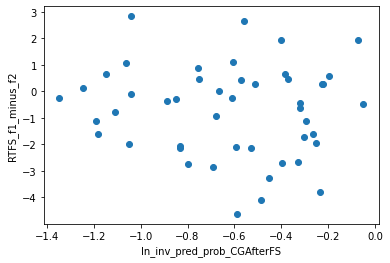

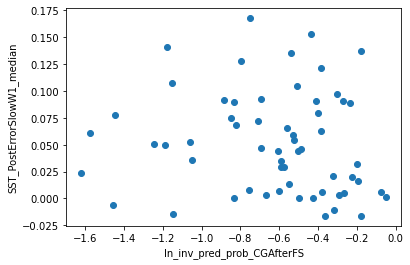

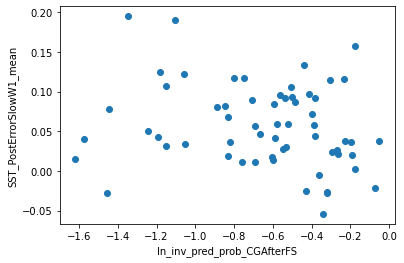

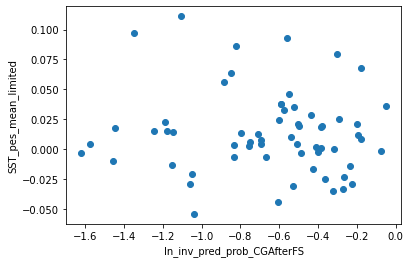

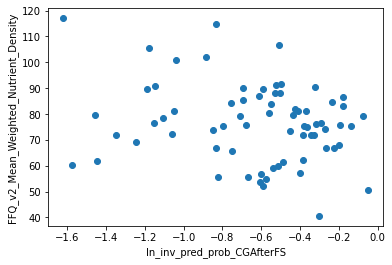

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_emotion regulation_association-test_z_FDR_0.01.pkl
emotion regulation_association-test_z_FDR_0.01
913.3456790123457


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


KeyboardInterrupt: 

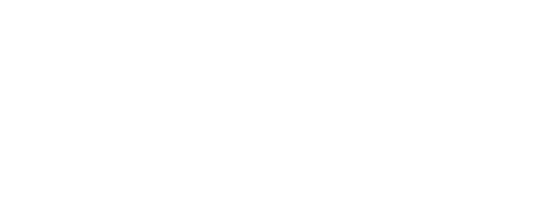

In [44]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_" +
        mask_name
        + ".pkl"
    )
    print(brain_data_filepath)
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])

        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results

        
        print_forced_choice_results(
            forced_choice_results,
            individual_differences,
            ['ln_inv_pred_prob_CGAfterCS'],
            behavioral_measures = pes_vars_of_interest,
            target_y='CorrectGoFollowingCorrectStop')
        print_forced_choice_results(
            forced_choice_results,
            individual_differences,
            ['ln_inv_pred_prob_CGAfterFS'],
            behavioral_measures = pes_vars_of_interest,
            target_y='CorrectGoFollowingFailedStop')

### whole brain, conditions separate

In [45]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])


print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterCS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingCorrectStop')
print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterFS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingFailedStop')

print(prediction,forced_choice_prediction)

whole brain
122853.14814814815
.....................................................................

KeyboardInterrupt: 

## PES contrast...

whole brain
emotion regulation_association-test_z_FDR_0.01
131510.78787878787


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


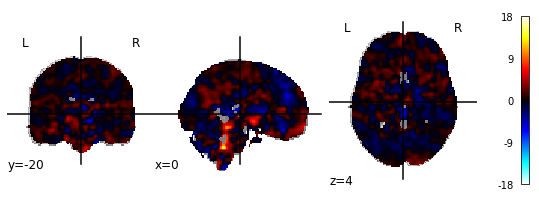

...

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.45747e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.3864e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.39624e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.44474e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.44306e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.82022e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.5189e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.45122e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.81871e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.39293e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.63711e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.64581e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.56116e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.4974e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


...

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.53823e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.52875e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.78585e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.60025e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.6012e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.73376e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.46749e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.5119e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.23955e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.49616e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.55139e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.34081e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.30068e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.87874e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.5145e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.69449e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.56085e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.4755e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.46824e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.42316e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.5967e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.65153e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


...

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.37957e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.51924e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.72934e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.49086e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.13395e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.50092e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.50072e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.78394e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.54678e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.68681e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.24651e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.62456e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.37326e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.46149e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.58128e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.49894e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.86418e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.35088e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.62708e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.50725e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.22301e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.52753e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.2523e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.48796e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.34142e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.42141e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


.


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.40929e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.3919e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


NameError: name 'individual_differences' is not defined

In [46]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_contrast.pkl"
)

target='SST_pes_mean_limited'

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

print(mask_name)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(masked_preview,vmax=18)
plotting.show()
forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
print("")


forced_choice_results_dict[mask_name]=forced_choice_results
print_regression_results(
    forced_choice_results,['mae'],
    [target])


prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

print(prediction,forced_choice_prediction)

negative affect_association-test_z_FDR_0.01
1204.3484848484848


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


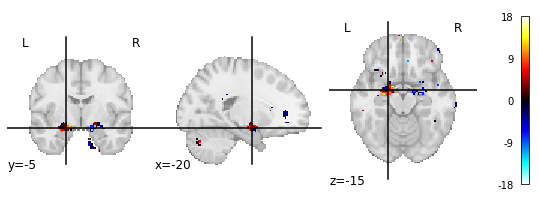

.....................

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.87853e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.48889e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.57349e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22174e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwri

...................

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.04161e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24913e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.81707e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.97903e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwri

...................

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.46849e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29862e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.86217e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.82492e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwri

.......
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.11242e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.074e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.36842e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.88923e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite

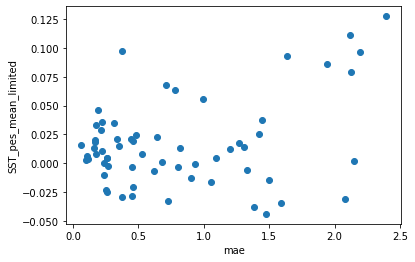

emotion regulation_association-test_z_FDR_0.01
972.560606060606


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


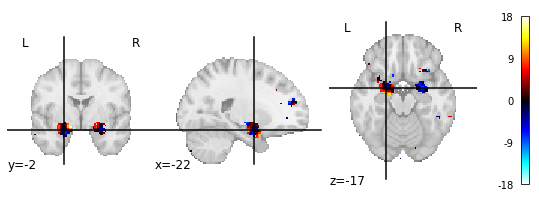

.........................................

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.22439e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.73137e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.6525e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.17102e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrit

.........................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.63786e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.28901e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.4655e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.7742e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite

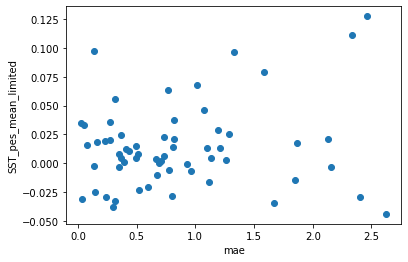

harvardoxford-cortical_prob_Frontal Medial Cortex
1882.439393939394


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


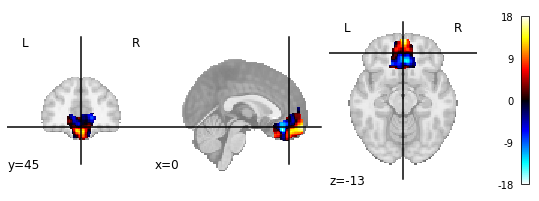

....................................

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.99985e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.07627e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.9876e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.74672e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrit

..............................


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.06669e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.1097e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.45857e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.04338e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrit

Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'FFQ_v2_Mean_Weighted_percent_daily_value',
       'FFQ_v2_Mean_Dietary_Nutrient_Density', 'FFQ_v2_Mean_Energy_Density',
       'FFQ_v2_Mean_Energy', 'wave', 'subj_wave', 'chunks', 'target_y',
       'pred_y', 'mae'],
      dtype='object', length=144)


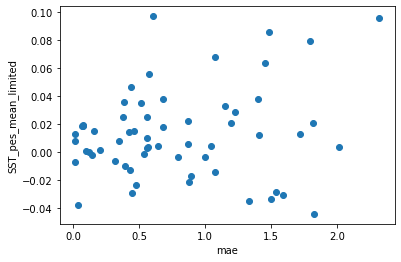

In [62]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_contrast_" +
        mask_name
        + ".pkl"
    )
    
    if os.path.exists(brain_data_filepath):

        target='SST_pes_mean_limited'

        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)

        Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
        print("")

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_regression_results(forced_choice_results,['mae'],[target])

the mae is diverging in a way which suggests there is mae correlation with the variable itself, which isn't very meaningful.